In [2]:
import visisipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helpers import InputOutputAngles

In [3]:
geometry_parameters = {
    "axial_length": 24.305,  # mm
    "cornea_thickness": 0.5615,  # mm
    "anterior_chamber_depth": 3.345,  # mm
    "lens_thickness": 3.17,  # mm
    "cornea_front_radius": 7.6967,  # mm
    "cornea_front_asphericity": -0.2304,
    "cornea_back_radius": 6.2343,  # mm
    "cornea_back_asphericity": -0.1444,
    "pupil_radius": 0.5,  # mm
    "lens_front_radius": 10.2,  # mm
    "lens_front_asphericity": -3.1316,
    "lens_back_radius": -5.4537,  # mm
    "lens_back_asphericity": -4.1655,
    "retina_radius": -11.3357,  # mm
    "retina_asphericity": -0.0631,
}

geometry = visisipy.models.create_geometry(**geometry_parameters)
model = visisipy.models.EyeModel(geometry=geometry)

In [4]:
field_angles = np.arange(0, 90, 5).astype(float)

raytrace_results = visisipy.analysis.raytrace(model, coordinates=zip(len(field_angles) * [0], field_angles))

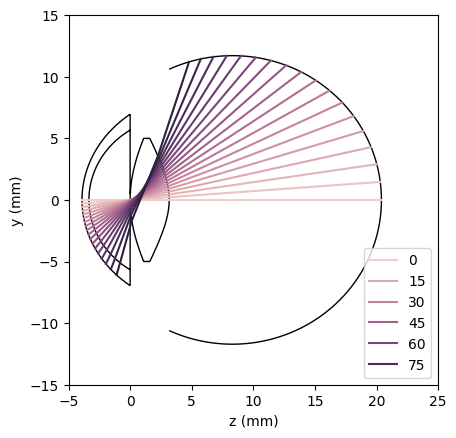

In [5]:
fig, ax = plt.subplots()

visisipy.plots.plot_eye(ax, model, lens_edge_thickness=0.5)
sns.lineplot(data=raytrace_results, x="z", y="y", hue=[f[1] for f in raytrace_results.field], ax=ax)

ax.set_aspect("equal")
ax.set_xlim(-5, 25)
ax.set_ylim(-15, 15)
ax.set_xlabel("z (mm)")
ax.set_ylabel("y (mm)")

sns.move_legend(ax, "lower right")

In [6]:
# Calculate cardinal point locations
cardinal_points = visisipy.analysis.cardinal_points(model)

# Get the location of the second nodal point with respect to the pupil location, which is the origin in OpticStudio
second_nodal_point = cardinal_points.nodal_points.image + (geometry.lens_thickness + geometry.vitreous_thickness)

# In the Navarro model, the second nodal point is located 7.45 mm behind the cornea apex
second_nodal_point_navarro = 7.45 - (geometry.cornea_thickness + geometry.anterior_chamber_depth)

# Calculate the location of the retina center
retina_center = geometry.lens_thickness + geometry.vitreous_thickness + geometry.retina.half_axes.axial

In [7]:
input_output_angles = pd.DataFrame([InputOutputAngles.from_ray_trace_result(g.set_index("index"), np2=second_nodal_point, np2_navarro=second_nodal_point_navarro, retina_center=retina_center) for _, g in raytrace_results.groupby("field")])

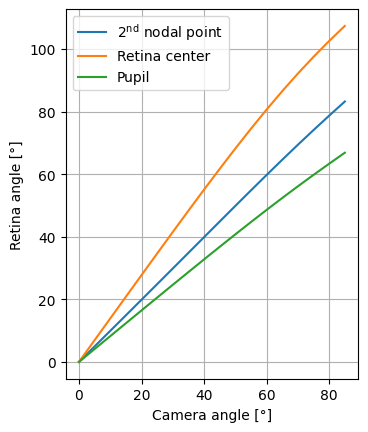

In [8]:
fig, ax = plt.subplots()

sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_np2",
    label="$2^{\\mathrm{nd}}$ nodal point",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_retina_center",
    label="Retina center",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_pupil",
    label="Pupil",
)

ax.set_xlabel("Camera angle [°]")
ax.set_ylabel("Retina angle [°]")
ax.set_aspect("equal")
ax.grid()